<a href="https://colab.research.google.com/github/adewoleopeyemi/NrMetricsProject/blob/master/NRMetricsExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install git+https://github.com/umang-singhal/pydom.git
!pip install image-quality
!unzip "/content/drive/My Drive/NightTimeImages.zip"
!unzip "/content/drive/My Drive/NoisyImages.zip"
!unzip "/content/drive/My Drive/FoggyDataset.zip"

  Cloning https://github.com/umang-singhal/pydom.git to /tmp/pip-req-build-4d0vx6ku
  Running command git clone -q https://github.com/umang-singhal/pydom.git /tmp/pip-req-build-4d0vx6ku
  Created wheel for pydom: filename=pydom-0.1-cp36-none-any.whl size=17989 sha256=4391288a9b2c192fa089dd9f7b0146e1bf1e71f42a98573165db8ed21cf727ff
  Stored in directory: /tmp/pip-ephem-wheel-cache-a_fvbbgj/wheels/4b/df/5b/1f7acae7f96c0b8fce3f2e4640100f7a297eab816f17bdb358
Successfully built pydom
     |████████████████████████████████| 153kB 5.2MB/s 
     |████████████████████████████████| 174kB 19.8MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp36-cp36m-linux_x86_64.whl size=233331 sha256=50b51dc65fb4f32f4b74b813b56f88a0623f359148618d7184f5c2f73addd82e
  Stored in directory: /root/.cache/pip/wheels/5e/9e/b5/dbb033107407eec2f52b8cd24cf024a4b9ec8b62ea5aee995a
Successfully built libsvm
Archive:  /content/drive/My Drive/NightTimeImages.zip
  inflating: testcam1.jpg            
  inflating: te

In [76]:
import cv2
import numpy as np
from skimage import io, img_as_float
import imquality.brisque as brisque
from dom import DOM
from skimage.restoration import estimate_sigma
import math
from google.colab.patches import cv2_imshow
import os


class NR_METRICS():
  def __init__(self, image_path, noisy=False, foggy=False, blurry=False):
    self.img_path = image_path
    self.noisy = noisy
    self.blurry = blurry
    self.foggy = foggy

  def get_sharpness(self, img):
    iqa = DOM()
    # using image path
    sharpness_score = iqa.get_sharpness(img)
    print("Sharpness: ", sharpness_score)
    return sharpness_score

  def get_BRISQUE_score(self, img):
    img = img
    BRISQUE_score = brisque.score(img)
    print("BRISQUE Score for image blur = ", BRISQUE_score)
    return BRISQUE_score

  def estimate_noise(self, img):
      img = img
      return estimate_sigma(img, multichannel=True, average_sigmas=True)
  
  def apply_filter(self, kernel_size, kernel_type):
    #kernel_size is int corresponding to the kernel
    img = cv2.imread(self.img_path)
    if kernel_type == "Average":
      kernel= np.ones((kernel_size, kernel_size), np.float32)/kernel_size**2
    elif kernel_type == "Gaussian":
      kernel = np.random.normal(size=(kernel_size))

    filtered_image = cv2.filter2D(img, -1, kernel)
    cv2_imshow(filtered_image)
    cv2.imwrite("/content/filter.jpg", filtered_image)

    return filtered_image

  def apply_median_blur(self, img, kernel_size):
    img = img
    medianblurred_image = cv2.medianBlur(img, kernel_size)
    return medianblurred_image

  def apply_bilateral_filter(self, kernel_size):
    img = cv2.imread(self.img_path)
    bilateral_filtered_image = cv2.bilateralFilter(img, kernel_size, 300, 300)
    cv2.imwrite("/content/filter.jpg", bilateral_filtered_image)
    cv2_imshow(bilateral_filtered_image)
    return bilateral_filtered_image


  def sharpen_image(self, img, sharpen_factor):
    img = img
    sharpening_filter = np.array([[-1.01, -1.01, -1.01],
                              [-1.01, sharpen_factor, -1.01],
                              [-1.01, -1.01, -1.01]])

    sharpened_image = cv2.filter2D(img, -1, sharpening_filter)
    return sharpened_image

  def increase_brightness_and_contrast(self, img,alpha, beta):
    img = img
    result = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 1, alpha)
    return result

  def _DarkChannel(self, im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b);
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark
 
  def _AtmLight(self, im,dark):
      [h,w] = im.shape[:2]
      imsz = h*w
      numpx = int(max(math.floor(imsz/1000),1))
      darkvec = dark.reshape(imsz,1);
      imvec = im.reshape(imsz,3);
  
      indices = darkvec.argsort();
      indices = indices[imsz-numpx::]
  
      atmsum = np.zeros([1,3])
      for ind in range(1,numpx):
        atmsum = atmsum + imvec[indices[ind]]
  
      A = atmsum / numpx;
      return A
  
  def _TransmissionEstimate(self, im,A,sz, omega):
      omega = omega;
      im3 = np.empty(im.shape,im.dtype);
  
      for ind in range(0,3):
          im3[:,:,ind] = im[:,:,ind]/A[0,ind]
  
      transmission = 1 - omega*self._DarkChannel(im3,sz);
      return transmission
  
  def _Guidedfilter(self, im,p,r,eps):
      mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
      mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
      mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
      cov_Ip = mean_Ip - mean_I*mean_p;
  
      mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
      var_I   = mean_II - mean_I*mean_I;
  
      a = cov_Ip/(var_I + eps);
      b = mean_p - a*mean_I;
  
      mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
      mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));
  
      q = mean_a*im + mean_b;
      return q;
  
  def _TransmissionRefine(self, im,et):
      gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
      gray = np.float64(gray)/255;
      r = 60;
      eps = 0.0001;
      t = self._Guidedfilter(gray,et,r,eps);
  
      return t;
  
  def _Recover(self, im,t,A,tx = 0.1):
      res = np.empty(im.shape,im.dtype);
      t = cv2.max(t,tx);
  
      for ind in range(0,3):
          res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]
  
      return res

  def defog(self, img, omega):
    src = img
    I = src.astype('float64')/255
    dark = self._DarkChannel(I,15)
    A = self._AtmLight(I,dark)
    te = self._TransmissionEstimate(I,A,15, omega)
    t = self._TransmissionRefine(src,te)
    J = self._Recover(I,t,A,0.1)
    arr = np.hstack((I, J))
    defogged_image = arr*255

    return defogged_image

  def add_noise(self, noise_type):

      img = cv2.imread(self.img_path)    
      if noise_type == "gauss":
          row,col,ch= img.shape
          img = img/255.
          mean = 0
          var = 0.1
          sigma = var**0.5
          gauss = np.random.normal(mean,var,(row,col,ch))
          gauss = gauss.reshape(row,col,ch)
          noisy = img + gauss
          cv2_imshow(noisy*255)
          cv2.imwrite("/content/gaussian.jpg", noisy*255)
          return noisy*255
      elif noise_type == "s&p":
          row,col,ch = img.shape
          s_vs_p = 0.5
          amount = 0.04
          out = np.copy(img)
          # Salt mode
          num_salt = np.ceil(amount * img.size * s_vs_p)
          coords = [np.random.randint(0, i - 1, int(num_salt))
                  for i in img.shape]
          out[coords] = 1

          # Pepper mode
          num_pepper = np.ceil(amount* img.size * (1. - s_vs_p))
          coords = [np.random.randint(0, i - 1, int(num_pepper))
                  for i in img.shape]
          out[coords] = 0
          cv2_imshow(out)
          cv2.imwrite("/content/s&p.jpg", out)
          return out
      elif noise_type =="speckle":
          row,col,ch = img.shape
          gauss = np.random.randn(row,col,ch)
          gauss = gauss.reshape(row,col,ch)        
          noisy = img + img * gauss
          cv2_imshow(noisy)
          cv2.imwrite("/content/speckle.jpg", noisy)
          return noisy


  def main(self):
    # get BRISQUE score: threshold brisque score to 50
    # get sharpness score: threshold sharpness score to 93
    # get estimate noise value

    img = cv2.imread(self.img_path)
    original_brisque_score = self.get_BRISQUE_score(img)
    original_sharpness = self.get_sharpness(img)
    original_noise = self.estimate_noise(img)

    brisque = original_brisque_score
    sharpness = original_sharpness

    filter_init = 5
    if (brisque > 45.0 or sharpness < 93) and self.noisy == True:
      medianx_blurred_image = self.apply_median_blur(img,filter_init)
      sharpened_median_blurred_image = self.sharpen_image(medianx_blurred_image, 9.0)
      median_blurred_image = self.apply_median_blur(sharpened_median_blurred_image,filter_init-2)
      cv2_imshow(img)
      cv2_imshow(median_blurred_image)
      #uncomment this line to return metrics
      #return (img, median_blurred_image, {"original_image_BRISQUE_SCORE":self.get_BRISQUE_score(img),"Processed_image_BRISQUE_score": self.get_BRISQUE_score(median_blurred_image)});

          
    elif self.foggy == True:
      defogged_img = self.defog(img, 0.95)
      cv2_imshow(img)
      cv2_imshow(defogged_img)
      #uncomment this line to return metrics
      #return (img, defogged_img, {"original_image_BRISQUE_SCORE":self.get_BRISQUE_score(img),"Processed_image_BRISQUE_score": self.get_BRISQUE_score(defogged_img)});

    else:
      sharpened_img = self.sharpen_image(medianx_blurred_image, 9.0)
      cv2_imshow(img)
      cv2_imshow(sharpened_img)
      #uncomment this line to return metrics
      #return (img, sharpened_img, {"original_image_BRISQUE_SCORE":self.get_BRISQUE_score(img),"Processed_image_BRISQUE_score": self.get_BRISQUE_score(sharpened_img)});


In [77]:
result = NR_METRICS("/content/drive/My Drive/clear.jpg", noisy  = False, foggy=True, blurry=False)

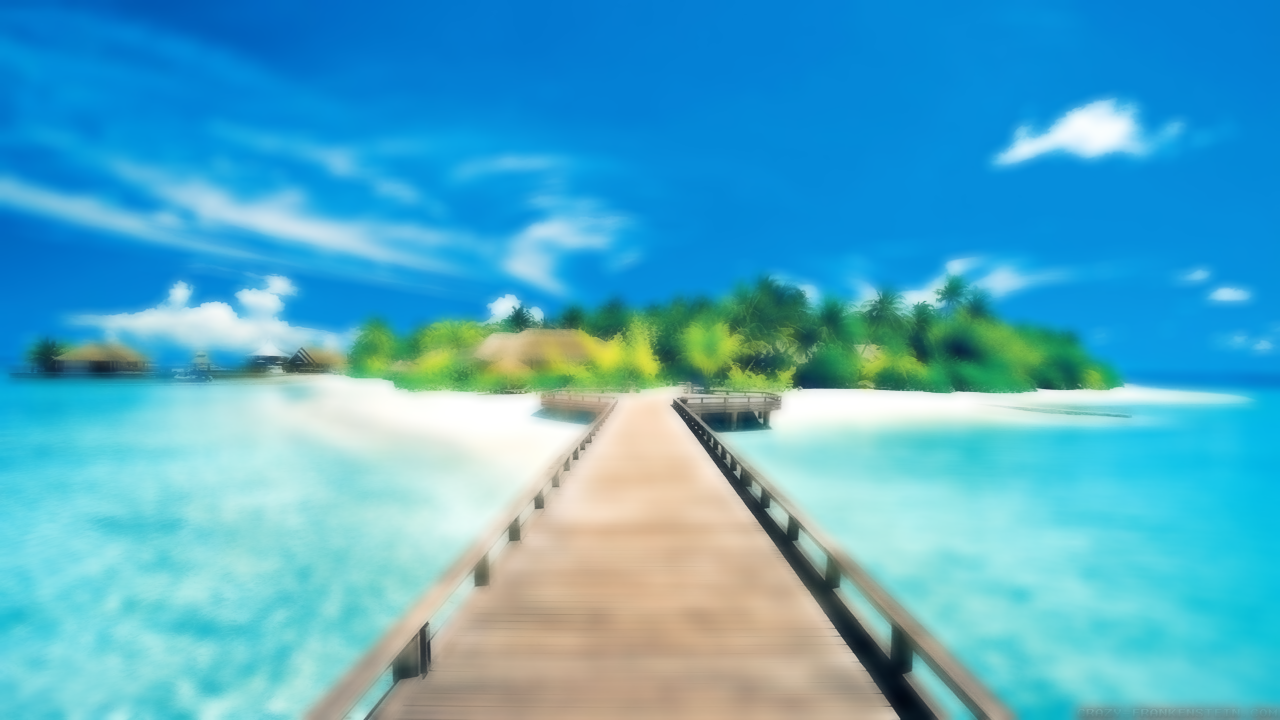

array([[[193, 105,   1],
        [193, 105,   1],
        [193, 105,   1],
        ...,
        [209, 126,   4],
        [209, 126,   4],
        [209, 126,   4]],

       [[193, 105,   1],
        [193, 105,   1],
        [193, 105,   1],
        ...,
        [209, 126,   4],
        [209, 126,   4],
        [209, 126,   4]],

       [[193, 106,   1],
        [193, 106,   1],
        [193, 106,   1],
        ...,
        [209, 126,   4],
        [209, 126,   4],
        [209, 126,   4]],

       ...,

       [[212, 199,  80],
        [211, 199,  79],
        [211, 199,  78],
        ...,
        [149, 144,  85],
        [151, 145,  85],
        [151, 145,  85]],

       [[211, 199,  79],
        [211, 198,  78],
        [211, 199,  78],
        ...,
        [151, 146,  88],
        [152, 146,  88],
        [152, 145,  87]],

       [[211, 199,  79],
        [211, 199,  79],
        [212, 200,  80],
        ...,
        [152, 146,  89],
        [152, 146,  88],
        [153, 146,  88]]

In [78]:
result.apply_median_blur()

None
